<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Linear Regression and KNN - Train/Test Split

---

# Introduction

We've discussed overfitting in the context of bias and variance, and we've touched on some techniques, such as regularization, that are used to avoid overfitting (but haven't practiced them yet). In this lesson we'll discuss a fundamental method for avoiding overfitting that is commonly referred to as _train/test split_ validation. 

The idea is similar to something called "cross-validation" — in fact, it is a type of cross-validation — in that we split the data set into two subsets:
* A subset on which to train our model.
* A subset on which to test our model's predictions.

This serves two useful purposes:
* We prevent overfitting by not using all of the data.
* We have some remaining data we can use to evaluate our model.

While this may seem like a relatively simple idea, **there are some caveats** to putting it into practice. For example, if you are not careful, it is easy to take a non-random split. Suppose we have salary data on technical professionals that is composed of 80 percent data from California and 20 percent data from elsewhere and is sorted by state. If we split our data into 80 percent training data and 20 percent testing data, we might inadvertantly select all the California data to train and all the non-California data to test. In this case we've still overfit on our data set because we did not sufficiently randomize the data.

In a situation like this we can use _k-fold cross-validation_, which is the same idea applied to more than two subsets. In particular, we partition our data into $k$ subsets and train on $k-1$ one of them, holding the last slice for testing. We can do this for each of the possible $k-1$ subsets.

# Independent Practice

Ultimately we use a test-training split to compare multiple models on the same data set. This could be comparisons of two linear models or of completely different models on the same data.

For your independent practice, fit three different models on the Boston housing data. For example, you could pick three different subsets of variables, one or more polynomial models, or any other model you'd like. 

### Here's What We Will Be Doing:

* Working with Boston housing data to predict the value of a home
* Create a test-train split of the data.
* Train each of your models on the training data.
* Evaluate each of the models on the test data.
* Rank the models by how well they score on the testing data set.

**Then, try k-folds.**

* Try a few different splits of data for the same models.
* Perform a k-fold cross-validation and use the cross-validation scores to compare your models. Did this change your rankings?

**Be sure to provide interpretation for your results.**

Recall that k-fold cross-validation creates a hold portion of your data set for each iteration of training and validating:

![](http://i.imgur.com/0PFrPXJ.png)

## Linear Regression Use Case

In this given task, you will be asked to model the median home price of various houses across U.S. Census tracts in the city of Boston. This is a probable use case: We are predicting a continuous, numeric output (price) based on a combination of discrete features.

In [2]:
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_boston

boston = load_boston()

X = pd.DataFrame(boston.data,
                 columns=boston.feature_names)
y = pd.DataFrame(boston.target,
                 columns=['MEDV'])

print(boston['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

### 1. Clean Up Data and Perform Exporatory Data Analysis

Boston data is from scikit-learn, so it ought to be pretty clean, but we should always perform exploratory data analysis.

In [4]:
# Exploratory data analysis.

# Include: total nulls, index, data types, shape, summary statistics, and the number of unique values for each column
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null float64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null float64
TAX        506 non-null float64
PTRATIO    506 non-null float64
B          506 non-null float64
LSTAT      506 non-null float64
dtypes: float64(13)
memory usage: 51.5 KB


In [6]:
X.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


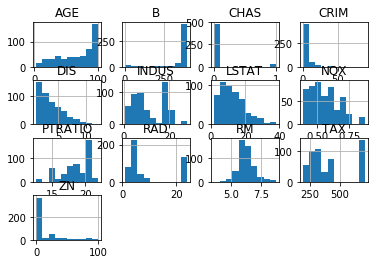

In [7]:
X.hist();

In [8]:
c = pd.DataFrame(X.corr().abs().unstack().sort_values(ascending = False))
c.columns = ['corr']
c[c['corr'] < 1].drop_duplicates()

,,corr
RAD,TAX,0.910228
DIS,NOX,0.769230
INDUS,NOX,0.763651
AGE,DIS,0.747881
NOX,AGE,0.731470
TAX,INDUS,0.720760
DIS,INDUS,0.708027
NOX,TAX,0.668023
DIS,ZN,0.664408
INDUS,AGE,0.644779


In [9]:
y.describe()

,MEDV
count,506.000000
mean,22.532806
std,9.197104
min,5.000000
25%,17.025000
50%,21.200000
75%,25.000000
max,50.000000


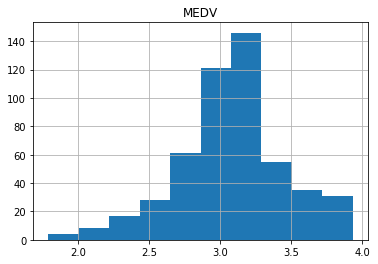

In [10]:
# y.hist();
np.log1p(y).hist();

### Analysis of EDA:

1. There are no non-null values in our data, and therefore no values to impute.
2. RAD and TAX features are very highly correlated (abs > 0.9), suggesting a strong relationship between the two features. Therefore, at least one of these variables should not be included, as they are more likely to dampen the other's predictive power.
3. There is significant clustering and high variance in the data, and since Linear Regression and KNN models make assumptions about the shape of the data, the features will be standardized as part of our pre-processing. Additionally, the y values will be log+1 transformed to improve the predictions, a transformation which will require the inverse transformation after predictions are generated.

In [11]:
# Standardization of features
X = (X - X.mean()) / X.std()

In [12]:
# log+1 transformation of target
y = np.log1p(y)

## Using `scikit-learn` Linear Regression

### 2. Pick 3-4 predictors (i.e. CRIM, ZN, etc...) that you will use to predict our target variable, MEDV.
Score and plot your predictions. What do these results tell us?

In [13]:
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split

In [14]:
y = y['MEDV']

In [15]:
cols = ['CHAS','RAD','TAX','ZN']

In [16]:
lr = LinearRegression()
lr.fit(X[cols],y)
lr.score(X[cols],y)
# lr.fit(X,y)
# lr.score(X,y)

0.38096533662889087

In [17]:
coeffs = pd.DataFrame({
    'Vars': X[cols].columns,
    'Weight': lr.coef_
}).sort_values(by='Weight', ascending=False)

coeffs

,Vars,Weight
3,ZN,0.086792
1,RAD,0.072758
0,CHAS,0.056929
2,TAX,-0.253147


### Conclusion:
ZN, RAD, and CHAS are all comparably strong predictors, while TAX is less so. Overall, the R-squared score of 0.38 is significantly worse than when using all of the features, suggesting that too much is lost by these variable choices. In this case I would probably consider a subtractive feature selection process over an additive one, at least for the Linear Regression model.

### 3. Try 70/30 and 90/10 train/test splits (70% of the data for training - 30% for testing, then 90% for training - 10% for testing)
Score and plot. How do your metrics change? What does this tell us about the size of training/testing splits?

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X[cols], 
                                                    y, 
                                                    test_size = 0.3, 
                                                    random_state=2019)

In [19]:
lr.fit(X_train, y_train)
print("Train Score: {}, Test Score: {}".format(lr.score(X_train, y_train), lr.score(X_test, y_test)))

Train Score: 0.3856403518140561, Test Score: 0.35053922216379774


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X[cols], 
                                                    y, 
                                                    test_size = 0.1, 
                                                    random_state=2019)

In [21]:
lr.fit(X_train, y_train)
print("Train Score: {}, Test Score: {}".format(lr.score(X_train, y_train), lr.score(X_test, y_test)))

Train Score: 0.373166944132569, Test Score: 0.437820100183711


### Conclusion:

Due to relatively low R-scores, the different in the 70/30 vs 90/10 train/test splitting is not very pronounced, at least in the training data. What is significant is the dramatic difference between the training and testing scores in the 90/10 split data. One might at first be pleasantly surprised by seeing such a large improvement between the training and testing scores, but in practice it would be more helpful to be able to deploy a model with more predictable results. Such a model may have a high amount of variance when applied to new data, and is therefore difficult to anticipate its actual performance when deployed in production.

### 4. Use k-fold cross validation varying the number of folds from 5 to 10
What seems optimal? How do your scores change? What is the variance like? Try different folds to get a sense of how this impacts your score. What are the tradeoffs associated with choosing the number of folds?

In [22]:
# changing to 80/20 train/test split
X_train, X_test, y_train, y_test = train_test_split(X[cols], 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state=2019)

In [23]:
scores_5 = cross_val_score(estimator = lr,
                           X=X_train, 
                           y=y_train,
                           cv = 5)

In [24]:
print("Mean Score 5-fold CV: ",
      np.mean(scores_5),
      "\n",
      "Score STD 5-fold CV: ",
      np.std(scores_5))

Mean Score 5-fold CV:  0.33507737912173147 
 Score STD 5-fold CV:  0.1101337482275364


In [25]:
scores_10 = cross_val_score(estimator = lr,
                            X=X_train, 
                            y=y_train,
                            cv = 10)

In [26]:
print("Mean Score 10-fold CV: ",
      np.mean(scores_10),
      "\n",
      "Score STD 10-fold CV: ",
      np.std(scores_10))

Mean Score 10-fold CV:  0.34105753090399193 
 Score STD 10-fold CV:  0.10870223702906306


### Conclusion:
The higher numer of folds in cross-validation is modest, however in addition to the slight improvement in mean score, the scores also vary less, suggesting slightly improved confidence in the model's predictive capabilities.

### Practice:

Unsatisfied with these results, I'm going to attempt some other models and use all of the features.

In [1]:
from sklearn.linear_model import Ridge, Lasso

In [43]:
rr = Ridge()
lsr = Lasso()

# 80/20 train/test split, using all features except for RAD due to high correlation with TAX
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state=2019)

In [ ]:
# Simultaneously attempting Lasso and Ridge, tuning the alpha parameters for each

In [57]:
alphas = np.logspace(-4, 4, 9)
lsr_scores = []
rr_scores = []

for a in alphas:
    lsr.set_params(alpha = a)
    rr.set_params(alpha = a)
    scores = cross_val_score(estimator = lsr, X=X_train, y = y_train, cv = 10)
    lsr_scores.append((np.mean(scores), a))
    scores = cross_val_score(estimator = rr, X=X_train, y = y_train, cv = 10)
    rr_scores.append((np.mean(scores), a))

In [58]:
max(lsr_scores)

(0.7814572182231376, 0.001)

In [59]:
max(rr_scores)

(0.7820647667994132, 10.0)

In [61]:
lsr.set_params(alpha = 0.001)
lsr.fit(X_train, y_train)
lsr.score(X_test, y_test)

0.6836848455945553

In [62]:
rr.set_params(alpha = 10)
rr.fit(X_train, y_train)
rr.score(X_test, y_test)

0.6825821601357425

## Using Random Forests With the Boston Dataset

In [64]:
from sklearn.ensemble import RandomForestRegressor

#### Create X and y variables for Your Data

In [63]:
# reloading the data; we know that Random Forests do not make the assumptions about the data shape, so standardization
# will be skipped, although the target will still be logp1 transformed
X = pd.DataFrame(boston.data,
                 columns=boston.feature_names)
y = pd.DataFrame(boston.target,
                 columns=['MEDV'])
y = np.log1p(y)
y = y['MEDV']

#### Divide it into a training and test set

In [65]:
# 80/20 train/test split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state=2019)

#### Fit a Random Forest on the data

In [66]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

#### What are its most important features?

In [30]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances

,importance
LSTAT,0.576807
RM,0.203049
CRIM,0.082906
DIS,0.050465
NOX,0.029763
TAX,0.013119
B,0.011939
AGE,0.011817
PTRATIO,0.010032
INDUS,0.005907


### Conclusion:
In the Random Forest Classifier model, the LSTAT, RM, and CRIM features are the 3 most signifcant features in the dataset.

#### How well does your model perform on your test set?

In [67]:
rf.score(X_test, y_test)

0.787232157422018

### Conclusion:
The Random Forest Regressor model performs significantly better than the first Linear Regression model, however it is worth noting that the Linear Regression model above was limited to 4 features. Later, using more features models, we performed better, but still not as good as the Random Forest Regressor.

#### Challenge:  Try and find at least two improvements to your model to improve test scores.

You can try the following:
 - increasing the number of trees
 - using a different number of maximum features to sample
 - using a different number of minimum samples per leaf

In [68]:
# to conveniently optimize the random forest model, use three nested loops to tune 3 model parameters
rf_scores = []

n_tr = [1, 10, 25, 50, 100, 1000]
spl = [1, 2, 4, 8, 16, 32]
mx_ft = [1, 0.5, 'sqrt', 'log2', len(X_train.columns) - 1]

for t in n_tr:
    print("# Trees: ", t)
    for m in mx_ft:
        for s in spl:
            rf.set_params(n_estimators = t,
                          max_features = m, 
                          min_samples_leaf = s,
                          n_jobs = -1)
            scores = cross_val_score(estimator = rf, X = X_train, y = y_train, cv = 10)
            rf_scores.append((np.mean(scores), t, m, s))

# Trees:  1
# Trees:  10
# Trees:  25
# Trees:  50
# Trees:  100
# Trees:  1000


In [69]:
max(rf_scores)

(0.8714913193306769, 1000, 0.5, 1)

In [71]:
rf.fit(X_train, y_train)
rf.set_params(n_estimators = 1000,
              max_features = 0.5, 
              min_samples_leaf = 1)
rf.score(X_test, y_test)

0.8314223994333537

### Conclusion:
Some mild hyperparameter tuning suggests that the optimum paramters for the random forest are:
1. n_estimators (# trees) = 1000
2. max_features = 50% of features
3. min_samples_leaf = 1

### Example: Using the Statsmodels Formula

Adapt the formula example using your metrics. We will review this implementation in class. Here is a reference to consider. The workflow is the same, but the syntax is a little different. We want to get accustomed to the formula syntax because we will be using them a lot more with regressions. The results should be comparable to scikit-learn's regression models.

In [ ]:
# First, format our data in a DataFrame

df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['MEDV'] = boston.target
df.head()

In [ ]:
# Set up our new statsmodel.formula handling model
import statsmodels.formula.api as smf

# You can easily swap these out to test multiple versions/different formulas
formulas = {
    "case1": "MEDV ~ RM + LSTAT + RAD + TAX + NOX + INDUS + CRIM + ZN - 1", # - 1 = remove intercept
    "case2": "MEDV ~ NOX + RM",
    "case3": "MEDV ~ RAD + TAX"
}

model = smf.ols(formula=formulas['case1'], data=df)
result = model.fit()

result.summary()

### Bonus Challenge #1:

Can you optimize your R2, selecting the best features and using either test-train split or k-folds?

### Bonus Challenge #2:

Given a combination of predictors, can you find another response variable that can be accurately predicted through the exploration of different predictors in this data set?

_Tip: Check out pairplots, coefficients, and Pearson scores._

In [ ]:
# Check out variable relations
import seaborn as sns

sns.pairplot(X);

In [ ]:
# Check out Pearson scores


## Demo: Patsy

In [ ]:
import patsy

# Add response to the core DataFrame
df['MEDV'] = y

In [ ]:
from sklearn.model_selection import train_test_split #If you didn't import it earlier, do so now

# Easily change your variable predictors without reslicing your DataFrame
y, X = patsy.dmatrices("MEDV ~ AGE + RM", data=df, return_type="dataframe")

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7)


In [ ]:
from sklearn import metrics
from sklearn.linear_model import LinearRegression

# Rerun your model, iteratively changing your variables and train_size from the previous cell

lm = LinearRegression()
model = lm.fit(X_train, y_train)

predictions = model.predict(X_test)
print("R^2 Score: {}".format(metrics.r2_score(y_test, predictions)))